# Signal-to-Noise Ratio (SNR) Calculator - Hardware Implementation Explained

## What is SNR?

The Signal-to-Noise Ratio (SNR) tells us how much louder the desired signal is compared to unwanted background noise. It's expressed in decibels (dB):

$$\text{SNR}_{\text{dB}} = 20 \cdot \log_{10}\left(\frac{\text{signal}_{\text{rms}}}{\text{noise}_{\text{rms}}}\right)$$

Where:
* **signal_rms**: RMS value of the signal (short-term average)
* **noise_rms**: RMS value of the noise floor (long-term average)

The RMS (Root Mean Square) for a signal x[n] is approximated using a moving average of |x[n]|.

### SNR Quality Guidelines

A higher SNR indicates cleaner audio:
* **>40 dB**: Excellent quality (studio recording)
* **30-40 dB**: Good quality (FM radio)
* **20-30 dB**: Acceptable (AM radio)
* **<20 dB**: Poor quality (noisy connection)

## Moving Average Filter Approach
Instead of classifying individual samples, we use moving average filters with different time constants to estimate signal and noise levels:

**Noise Floor Estimation:**
* Use a long time constant
* Update during quiet periods
* Provides stable baseline noise measurement.

**Signal Level Estimation:**
* Use a short time constant
* Responds quickly to signal changes
* Captures dynamic signal envelope.

## Hardware Architecture for Moving Average SNR
The SNR calculator uses dual moving average (MA) filters with different time constants:


## Absolute value block:
Ensures RMS approximation uses magnitudes only. See how the code in the "Mic Input" task does it.

## Moving Average (MA) Filters:
The moving average filters can be implemented using Linear Constant Coefficient Difference Equations (LCCDEs), introduced in the lecture.

## Short MA filter (fast response):
* Implemented as exponential moving average (IIR):
* LCCDE: y[n]=y[n−1]+α(x[n]−y[n−1])
* α is larger → fast response.

## Long MA filter (slow response):
* LCCDE: y[n]=y[n−1]+α(x[n]−y[n−1])
* α is small → slower response.
* Update only when quiet_period=1.

---

## LCCDE Approach
Low-pass filter as opposed to high-pass provided in LLCDE Filter Design.

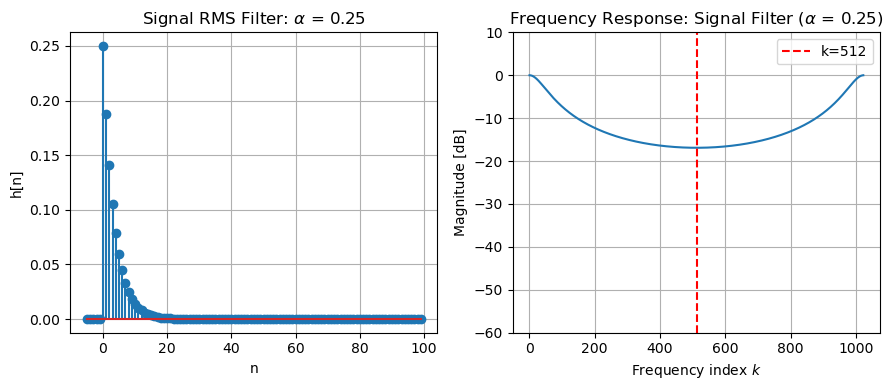

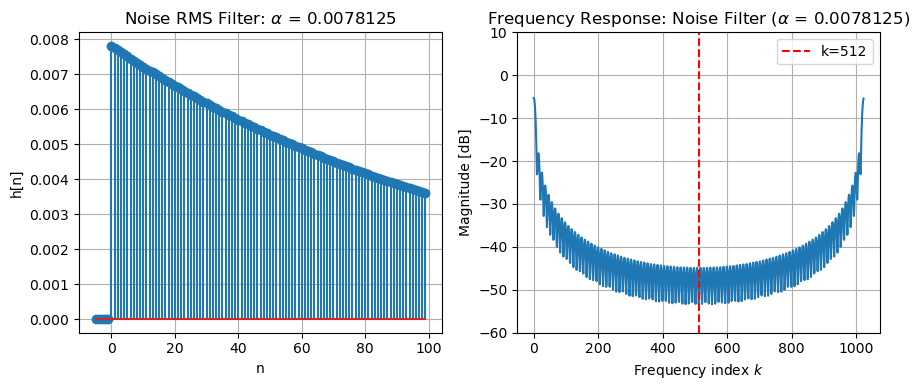

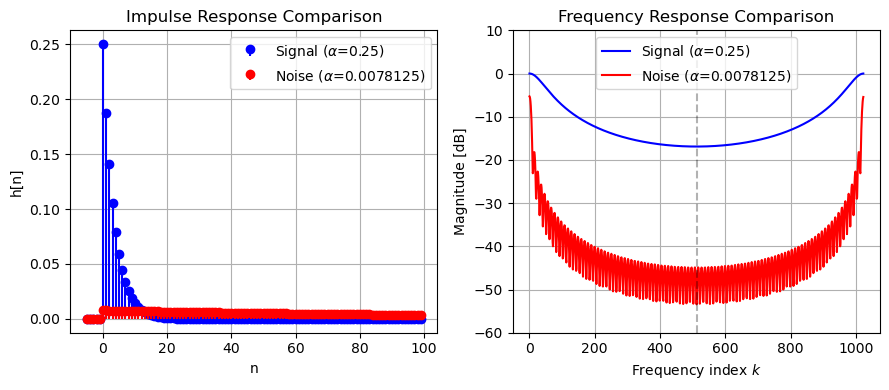

In [1]:
import numpy as np
import matplotlib.pyplot as plt

PLOT = True  # Set to true to plot h[n] and H[k]

# Parameters from your Verilog code
ALPHA_SIGNAL = 16384 / 65536  # 0.25 in Q0.16 format
ALPHA_NOISE = 512 / 65536      # 0.0078125 in Q0.16 format

# Impulse response h[n] for the LCCDE
N = 100
n = np.arange(-5, N)  # discrete-time axis: 100 samples, plus 5 negative n values

# Unit impulse input
x = np.zeros(N+5)  # +5 for the extra n=-1, n=-2, ..., n=-5 index
x[5] = 1           # x[n] = delta[n] unit impulse. Index 5 is n=0.

# ============ Signal RMS Filter (Fast, alpha = 0.25) ============
y_signal = np.zeros(N+5)
alpha = ALPHA_SIGNAL

for i in range(N):
    m = i+5  # start from n=0
    y_signal[m] = alpha * x[m] + (1 - alpha) * y_signal[m-1]

h_signal = y_signal  # impulse response

plt.figure(figsize=(9, 4))
plt.subplot(1, 2, 1)
plt.stem(n, h_signal)
plt.title(f"Signal RMS Filter: $\\alpha$ = {ALPHA_SIGNAL}")
plt.xlabel("n")
plt.ylabel("h[n]")
plt.grid()

# Frequency Response for Signal Filter
H_signal = np.fft.fft(h_signal, 1024)
mag_signal = np.abs(H_signal)
freq = np.arange(0, 1024)
dB_mag_signal = 20 * np.log10(mag_signal + 1e-10)  # avoid log(0)

plt.subplot(1, 2, 2)
plt.plot(freq, dB_mag_signal)
plt.title(f"Frequency Response: Signal Filter ($\\alpha$ = {ALPHA_SIGNAL})")
plt.ylabel("Magnitude [dB]")
plt.xlabel("Frequency index $k$")
plt.grid()
plt.ylim([-60, 10])
plt.axvline(x=512, color='r', linestyle='--', label='k=512')
plt.legend()
plt.tight_layout()
if PLOT: plt.show()

# ============ Noise RMS Filter (Slow, alpha = 0.0078125) ============
y_noise = np.zeros(N+5)
alpha = ALPHA_NOISE

for i in range(N):
    m = i+5  # start from n=0
    y_noise[m] = alpha * x[m] + (1 - alpha) * y_noise[m-1]

h_noise = y_noise  # impulse response

plt.figure(figsize=(9, 4))
plt.subplot(1, 2, 1)
plt.stem(n, h_noise)
plt.title(f"Noise RMS Filter: $\\alpha$ = {ALPHA_NOISE}")
plt.xlabel("n")
plt.ylabel("h[n]")
plt.grid()

# Frequency Response for Noise Filter
H_noise = np.fft.fft(h_noise, 1024)
mag_noise = np.abs(H_noise)
dB_mag_noise = 20 * np.log10(mag_noise + 1e-10)  # avoid log(0)

plt.subplot(1, 2, 2)
plt.plot(freq, dB_mag_noise)
plt.title(f"Frequency Response: Noise Filter ($\\alpha$ = {ALPHA_NOISE})")
plt.ylabel("Magnitude [dB]")
plt.xlabel("Frequency index $k$")
plt.grid()
plt.ylim([-60, 10])
plt.axvline(x=512, color='r', linestyle='--', label='k=512')
plt.legend()
plt.tight_layout()
if PLOT: plt.show()

# ============ Comparison Plot ============
plt.figure(figsize=(9, 4))
plt.subplot(1, 2, 1)
plt.stem(n, h_signal, linefmt='b-', markerfmt='bo', basefmt=' ', label=f'Signal ($\\alpha$={ALPHA_SIGNAL})')
plt.stem(n, h_noise, linefmt='r-', markerfmt='ro', basefmt=' ', label=f'Noise ($\\alpha$={ALPHA_NOISE})')
plt.title("Impulse Response Comparison")
plt.xlabel("n")
plt.ylabel("h[n]")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(freq, dB_mag_signal, 'b-', label=f'Signal ($\\alpha$={ALPHA_SIGNAL})')
plt.plot(freq, dB_mag_noise, 'r-', label=f'Noise ($\\alpha$={ALPHA_NOISE})')
plt.title("Frequency Response Comparison")
plt.ylabel("Magnitude [dB]")
plt.xlabel("Frequency index $k$")
plt.grid()
plt.ylim([-60, 10])
plt.axvline(x=512, color='k', linestyle='--', alpha=0.3)
plt.legend()
plt.tight_layout()
if PLOT: plt.show()

## SNR Calculator:
$$\text{SNR}_{\text{dB}} = 20 \cdot \log_{10}\left(\frac{\text{signal}_{\text{rms}}}{\text{noise}_{\text{rms}}}\right)$$

* Approximated using the following:

$$\text{SNR}_{\text{dB}} = 20 \cdot \left[ \log_{10}\left(\text{signal}_{\text{rms}}\right)-\log_{10}\left(\text{noise}_{\text{rms}}\right)\right]$$

* Fixed point used

# Log₁₀ Approximation Method

This function implements a fast, hardware-friendly approximation of log₁₀ using linear interpolation in log space.

## Step-by-Step Breakdown

### Step 1: Find the Most Significant Bit (MSB)

```verilog
for (msb=15; msb>=0; msb=msb-1)
    if (value[msb]) break;
```

- Locates the position of the highest set bit
- This gives us the integer part of log₂(value)
- Example: If `value = 1100₀₀₀₀₀₀₀₀₀₀₀₀₂`, then `msb = 15`

### Step 2: Extract the Fractional Part

```verilog
fraction = (value << (15-msb)) >> 8;
```

- Left-shifts to align MSB to bit 15
- Right-shifts by 8 to extract the next 8 bits as a fraction
- This represents the mantissa or fractional component between powers of 2

### Step 3: Combine Integer and Fractional Parts

```verilog
(msb << 8) + fraction
```

- `msb << 8`: Integer part in fixed-point format (8.8 representation)
- `+ fraction`: Adds the fractional part
- Result: A linear approximation of log₂(value) in 8.8 fixed-point

### Step 4: Convert log₂ to log₁₀

```verilog
* 77) >>> 8
```

- Uses the conversion: $\log_{10}(x) = \log_2(x) \cdot \log_{10}(2)$
- $\log_{10}(2) \approx 0.301 \approx \frac{77}{256}$
- Multiplies by 77, then arithmetic right-shift by 8 (divide by 256)

## Summary

The approximation assumes a piecewise linear relationship between adjacent powers of 2, using the MSB position as the integer part and the following bits as a linear interpolation weight. This trades accuracy for speed and simplicity in hardware.

---

# Beat Detection - Instantaneous Energy

## The Intuition
When you hear a beat in music, it's often accompanied by a sudden increase in loudness (energy). Think of a kick drum - it creates a spike in energy. By tracking these energy spikes, we can detect beats!

## The Mathematics
Energy of a signal is proportional to the square of its amplitude:
$$E = \sum_{i} x_i^2$$

Where:
- $E$ = energy
- $x_i$ = signal amplitude at sample $i$

## The Process:
1. **Divide the signal into small windows** (e.g., 20ms each)
2. **Calculate energy for each window** (sum of squared samples)
3. **Detect beats based on a threshold** of energy. This could be adaptive (e.g. average energy).
4. **Apply BPM algorithm** (see *Section 3*).

# 3.1 BPM Estimator: Inter-Beat Interval (IBI) Analysis

## What is IBI?
Inter-Beat Interval is the time between consecutive beats. By finding when beats occur and measuring the time between them, we can directly calculate the tempo. This is the most intuitive approach - it's like tapping your foot to the music and measuring the time between taps.

## The Mathematics:
$$\text{BPM} = \frac{60}{\text{median}(\Delta t_i)}$$

Where $\Delta t_i$ is the time interval between consecutive beats. We could also use an average on the denominator, which is easy to calculate on an FPGA.

## The Approach:
1. **Find beat locations** using thresholding on the signal (like in *Section 2*)
2. **Calculate time intervals** between detected beats
3. **Use statistics** (median or mean) to find the typical interval
4. **Convert interval to BPM** using the above formula

## Pros \& Cons
### Advantages:
- Can detect tempo changes over time
- Simple to understand and implement

### Disadvantages:
- Sensitive to threshold selection
- May miss beats or detect false positives
- Prone to octave errors (detecting half or double tempo)

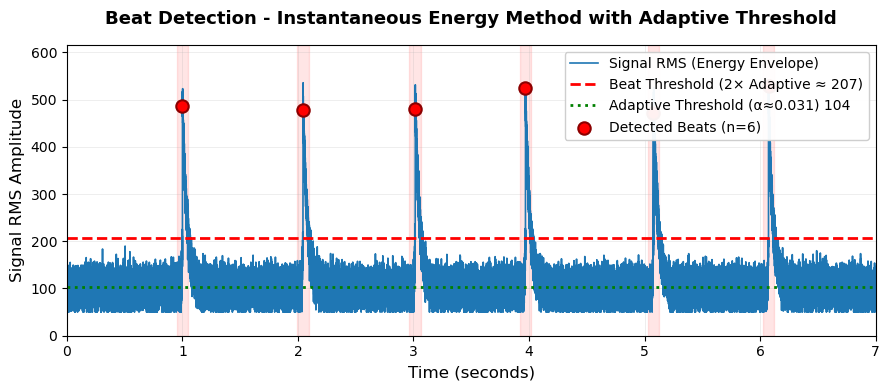

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Simulation parameters matching your hardware implementation
CLOCK_FREQ = 50_000_000  # 50 MHz
ALPHA_THRESHOLD = 2048 / 65536  # 0.03125 in Q0.16 format
THRESHOLD_MULT = 2  # 2x average energy
DEBOUNCE_MS = 50  # 50ms debounce

# Generate synthetic audio signal with beats
duration = 7  # seconds
sample_rate = 12000  # After decimation (48kHz / 4)
t = np.linspace(0, duration, duration * sample_rate)

# Create signal with periodic beats (120 BPM = 0.5s intervals)
signal_rms = np.ones_like(t) * 100  # Baseline noise floor

# Add beats at ~0.5 second intervals (120 BPM) with some variation
beat_positions_base = np.arange(1, duration, 1)
n_beats = len(beat_positions_base)
beat_positions = beat_positions_base + np.random.randn(n_beats) * 0.05

for beat_time in beat_positions:
    if beat_time < 0 or beat_time >= duration:
        continue
    # Create beat envelope (sharp attack, exponential decay)
    beat_idx = int(beat_time * sample_rate)
    
    # Attack phase (sharp rise) - reduced amplitude to 500
    attack_samples = int(0.01 * sample_rate)  # 10ms attack
    if beat_idx + attack_samples < len(signal_rms):
        attack = np.linspace(0, 1, attack_samples)
        signal_rms[beat_idx:beat_idx+attack_samples] += 100 * attack
    
    # Decay phase - reduced amplitude
    decay_samples = int(0.15 * sample_rate)  # 150ms decay
    if beat_idx + attack_samples + decay_samples < len(signal_rms):
        decay = np.exp(-np.linspace(0, 4, decay_samples))
        signal_rms[beat_idx+attack_samples:beat_idx+attack_samples+decay_samples] += 400 * decay

# Add realistic noise and variation
signal_rms += np.random.randn(len(signal_rms)) * 20
signal_rms = np.maximum(signal_rms, 50)  # Ensure non-negative

# Simulate adaptive threshold (EMA filter with α ≈ 0.03125)
adaptive_threshold = np.zeros_like(signal_rms)
adaptive_threshold[0] = signal_rms[0]

for i in range(1, len(signal_rms)):
    adaptive_threshold[i] = (adaptive_threshold[i-1] + 
                             ALPHA_THRESHOLD * (signal_rms[i] - adaptive_threshold[i-1]))

# Beat detection threshold (2x adaptive)
beat_threshold = THRESHOLD_MULT * adaptive_threshold

# Calculate average for comparison
average_energy = np.mean(signal_rms)

# Detect beats (rising edge detection)
beats_detected = []
last_above = False
debounce_counter = 0
debounce_samples = int((DEBOUNCE_MS / 1000) * sample_rate)

for i in range(len(signal_rms)):
    current_above = signal_rms[i] > beat_threshold[i]
    
    if debounce_counter > 0:
        debounce_counter -= 1
    elif current_above and not last_above:
        # Rising edge detected!
        beats_detected.append(i)
        debounce_counter = debounce_samples
    
    last_above = current_above

beat_times = t[beats_detected]
beat_amplitudes = signal_rms[beats_detected]

# Plot (similar style to first image)
plt.figure(figsize=(9, 4))

# Main energy plot
plt.plot(t, signal_rms, label='Signal RMS (Energy Envelope)', linewidth=1.2, color='#1f77b4')
plt.axhline(beat_threshold[0], color='r', linestyle='--', linewidth=2, 
           label=f'Beat Threshold (2× Adaptive ≈ {beat_threshold[0]:.0f})')
plt.axhline(adaptive_threshold[0], color='g', linestyle=':', linewidth=2, 
           label=f'Adaptive Threshold (α≈0.031) {adaptive_threshold[0]:.0f}')

# Mark detected beats with red dots - add label for legend
plt.scatter(beat_times, beat_amplitudes, color='red', s=80, zorder=5, 
           marker='o', edgecolors='darkred', linewidths=1.5, 
           label=f'Detected Beats (n={len(beats_detected)})')

# Formatting
plt.xlabel("Time (seconds)", fontsize=12)
plt.ylabel("Signal RMS Amplitude", fontsize=12)
plt.title("Beat Detection - Instantaneous Energy Method with Adaptive Threshold", 
         fontsize=13, fontweight='bold', pad=15)
plt.legend(loc='upper right', fontsize=10, framealpha=0.95)
plt.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
plt.xlim([0, duration])
plt.ylim([0, max(signal_rms) * 1.15])

# Add subtle background shading for detected beat regions
for bt in beat_times:
    plt.axvspan(bt - 0.05, bt + 0.05, alpha=0.1, color='red')

plt.tight_layout()
plt.savefig('beat_detection_energy_clean.png', dpi=300, bbox_inches='tight')
plt.show()